# Reproducibility of Results in *Bayesian Network-Informed Conditional Random Forests*

This notebook reproduces **Figures 1, 7 and 8** in the article **Bayesian Network-Informed Conditional Random Forests for Probabilistic Multisite Downscaling of Precipitation Occurrence**, submitted to *Water Resources Research*. It is provided alongside the functions required to train, predict and simulate using a Bayesian Network-Informed Conditional Random Forests ensemble (BNICRF) and the precipitation occurrence data to reproduced the results in the article.

The main functionalities to build bernoulli conditional random forests (CRF) are provided by the `R` package [RandomForestDist](https://github.com/MNLR/RandomForestDist), which was originally developed to reproduce the a posteriori random forests and experiments presented in the article [*A Posteriori Random Forests for Stochastic Downscaling of Precipitation by Predicting Probability Distributions*](https://doi.org/10.1029/2021WR030272), published in *Water Resources Research* by *Legasa et al.* in 2022.

In order to build the informative Bayesian network the package [bnlearn](https://www.bnlearn.com) is employed. 

### Installing Required Packages and Functions

[RandomForestDist](https://github.com/MNLR/RandomForestDist) requires a modified version of [rpart](https://cran.r-project.org/web/packages/rpart/index.html) which can be found [here](https://github.com/MNLR/rpart). In order to run the examples provided below, these two packages need to be installed. This can be easily done from GitHub using the `devtools` package: 

In [ ]:
devtools::install_github("MNLR/rpart")
install.packages(c("progressr", "qmap", "fitdistrplus, ROCR"))
devtools::install_github("MNLR/RandomForestDist@BNICRF")

In [ ]:
install.packages("BiocManager")
BiocManager::install()

We can install `bnlearn` from CRAN:

In [ ]:
install.packages("bnlearn")

### Loading Required Packages, Functions and Datasets

In [1]:
source("R/trainBNICRF.R")
source("R/predictBNICRF.R")
source("R/simulateBNICRF.R")
source("R/getConsecutiveDatesIndex.R")
source("R/getSpells.R")

load("data/train.data.rda") # train.data
load("data/test.X.rda") # test.X
load("data/test.Y.rda") # test.Y


Attaching package: ‘gRbase’


The following objects are masked from ‘package:bnlearn’:

    ancestors, children, nodes, parents


Loading required package: rpart

Loading required package: progressr

Loading required package: future



The data is already provided split into $5$ sequential folds (1979-1984, 1985-1990, 1991-1996, 1997-2002, 2003-2008).

`train.data` contains element `Y`, the discretized values of precipitation ocurrence; and `X`, the corresponding predictors (analogous for `test.X` and `test.Y`).

In [2]:
head(train.data$Y$f1_79_84$Data)

4007,4572,4472,4617,52,4083,4004,4079,4954,488,483
1,1,1,1,1,1,1,1,1,1,0
1,1,1,1,1,1,1,1,1,1,1
1,1,1,1,1,1,1,1,1,1,1
1,0,0,1,1,1,0,0,1,1,1
0,0,0,1,1,0,0,0,0,1,0
0,0,0,0,0,0,0,0,0,1,1


**Note**: `RandomForestDist` package uses `future.apply` package to speed up the computation by building the trees in parallel. It is also used by `simulateBNICRF()` to produce the simulations in parallel. By default, `trainBNICRF()` and `simulateBNICRF()` will use the `future::plan()` specified by the user:

In [3]:
if (require(future.apply)) {
    plan(multisession, workers = parallel::detectCores())
}

### Building an ensemble of Bayesian Network-Informed Conditional Random Forests (BNICRF) and reproducing Figure 1

The provided function `trainBNICRF()` trains an inforformative Bayesian network and the corresponding ensemble of conditional random forests (CRFs) for the set of stations provided in `y`. Several parameters can be passed to the function to control the configuration of the model. The most relevant ones are `tabu.list.size`, which controls the length of the tabu list used to train the Bayesian network; `minbucket`, corresponding to the minimum number of elements that each leaf in each CRF is required to have; `ntree`, the number of trees in each CRF; `max.parents` used to restrict the number of parents each node is allowed to have in the informative Bayesian network; and `mtry`, which controls the number of predictors to be used as each split candidate.

In [4]:
bnicrf <- trainBNICRF(y = train.data$Y$f1_79_84,
                      x = train.data$X$f1_79_84, 
                      tabu.list.size = 10^4, 
                      ntree = 100,
                      minbucket = 15, 
                      return.informativeBN = T)

[1] "Building Bayesian Network using tabu..."
[1] "Done building Bayesian Network."
[1] "Training Conditional Random Forests..."
[1] "Done."


We can use `predictBNICRF()` to predict the joint probability distribution of `y` from the trained model.

In [5]:
prediction <- predictBNICRF(bnicrf, test.X$f1_79_84)
head(prediction) # We show the JPD of the first days

P(4572),4083|4572=0,4083|4572=1,"4472|4572=0,4083=0","4472|4572=1,4083=0","4472|4572=0,4083=1","4472|4572=1,4083=1","4004|4572=0,4472=0,4083=0","4004|4572=1,4472=0,4083=0","4004|4572=0,4472=1,4083=0",⋯,"4079|52=0,4004=1,488=1","4079|52=1,4004=1,488=1","483|4083=0,4954=0,488=0","483|4083=1,4954=0,488=0","483|4083=0,4954=1,488=0","483|4083=1,4954=1,488=0","483|4083=0,4954=0,488=1","483|4083=1,4954=0,488=1","483|4083=0,4954=1,488=1","483|4083=1,4954=1,488=1"
0.61564902,0.56404230,0.9153713,0.09006211,0.7142857,0.2236559,0.7945439,0.143835616,0.41666667,0.3000000,⋯,0.7450980,0.8486352,0.070707071,0.28571429,0.5714286,0.7272727,0.07851240,0.35240964,0.5894737,0.7762712
0.27937400,0.34850455,0.8946322,0.03417969,0.3188406,0.1201550,0.5755694,0.098062954,0.00000000,0.1290323,⋯,0.7415730,0.8381503,0.008875740,0.21621622,0.2105263,0.8000000,0.08471074,0.37226277,0.2517483,0.6504854
0.26330275,0.57131902,0.9422572,0.05728314,0.5081967,0.1322902,0.7202572,0.108202443,0.04000000,0.0000000,⋯,0.7142857,0.8942598,0.023622047,0.13978495,0.4262537,0.5000000,0.12684366,0.25587467,0.3243243,0.6742349
0.05873783,0.17279047,0.7515723,0.04466019,0.2921348,0.1084337,0.5057915,0.030281182,0.02083333,0.1454545,⋯,0.5535714,0.8494624,0.025462963,0.47058824,0.4500000,0.3189824,0.14991763,0.39033457,0.2678571,0.6902174
0.04035530,0.02522676,0.4315789,0.01338240,0.3108108,0.1463415,0.5362319,0.004262575,0.01923077,0.1714286,⋯,0.5405405,0.7882353,0.007305195,0.08823529,0.2962963,0.2500000,0.15303430,0.10833333,0.4000000,0.6266667
0.05001947,0.03870968,0.5161290,0.01121495,0.4629630,0.1650485,0.5822785,0.005919220,0.05172414,0.1739130,⋯,0.6666667,0.8494624,0.003658537,0.09090909,0.2380952,0.5000000,0.08921933,0.02752294,0.4583333,0.7215190


And from the `prediction` object, we can produce simulations

In [6]:
simS <- simulateBNICRF(prediction, 
                       n = 10)
head(simS[[1]]) # We show the first simulated days for the first simulation

4007,4572,4472,4617,52,4083,4004,4079,4954,488,483
1,0,0,1,1,0,0,1,1,1,0
0,0,0,1,0,0,0,1,1,1,1
0,0,0,1,1,0,0,0,0,0,0
0,0,0,0,1,0,0,1,0,1,0
0,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,0


We can plot the DAG (stored in `attr(BNICRF, "informativeBN")`). If `BNWeatherGen` is available (Check https://github.com/MNLR/BNWeatherGen and the references herein), it will plot the locations considering their coordinates:

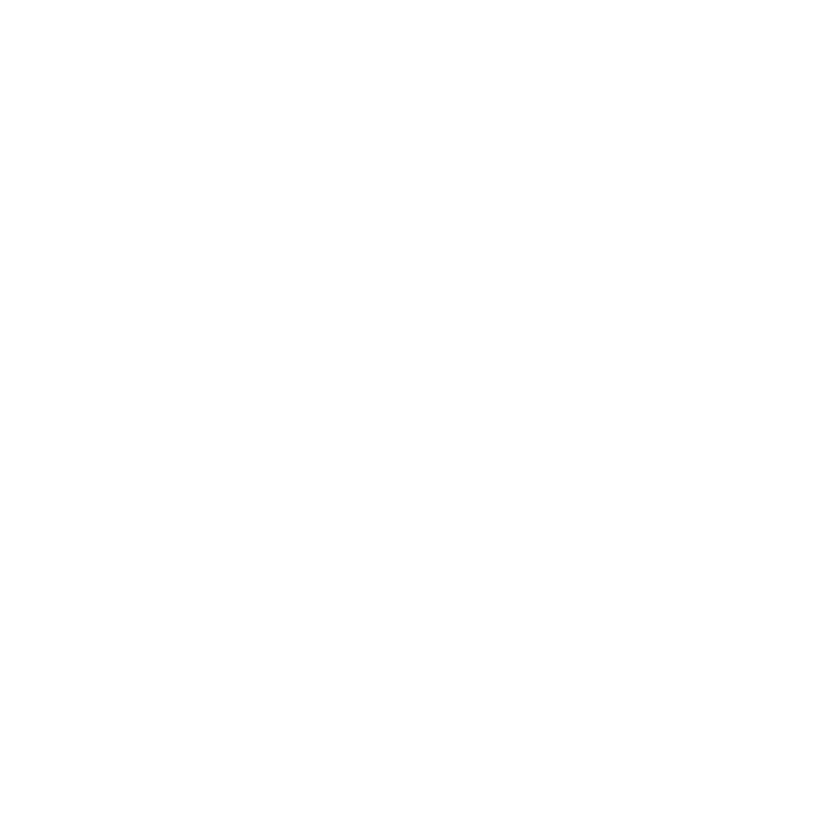

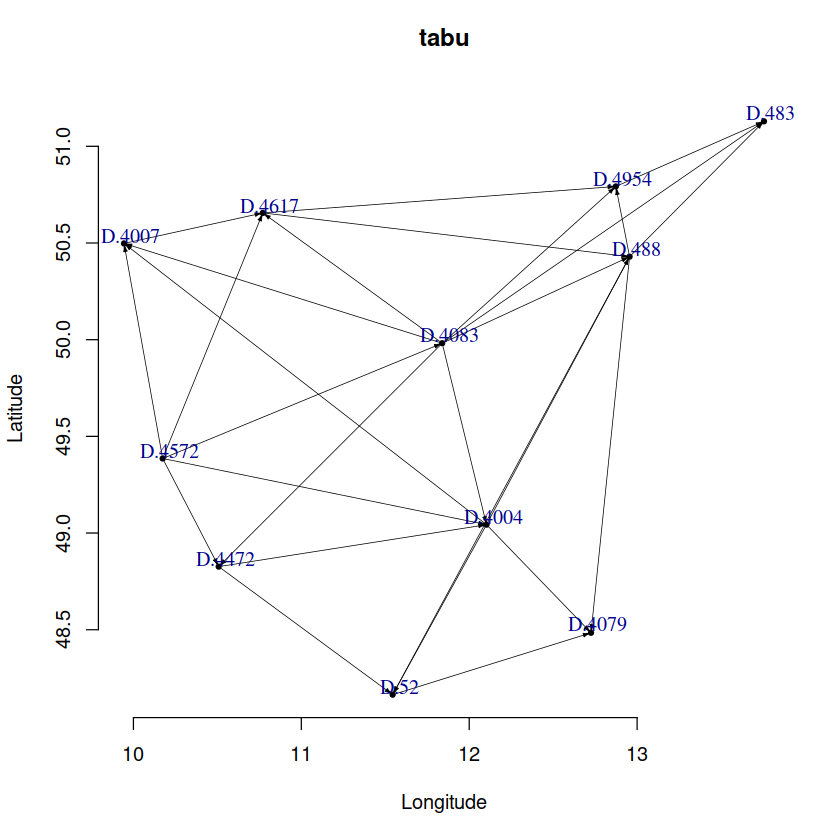

In [7]:
if (require(BNWeatherGen, quietly = T)) { 
  plotCBN( attr(bnicrf, "informativeBN"), return.plot = F ) 
} else {  plot( attr(bnicrf, "informativeBN") ) }

This is the directed acyclic graph shown in Figure 1 in the article, corresponding to the first fold.

## Reproducing Figures 8 and 9

We finally reproduce the results of the article by training $5$ BNICRFs (5-fold), producing 250 out-of-sample  simulations and validating them using different statistical measures. This will take a while:

In [8]:
number_of_simulations <- 250

simulations <-
  mapply(Y = train.data$Y, X = train.data$X, test.X = test.X,  # For each fold
         FUN = function(Y, X, test.X){
    bnicrf <- trainBNICRF(y = Y,
                          x = X, 
                          tabu.list.size = 10^5, # Using tabu list sizes this big takes a while
                          ntree = 100,
                          minbucket = 15, 
                          mtry = function(npredictors){ npredictors/3 })
    
    
    prediction <- predictBNICRF(bnicrf, test.X)                # Predict for the out-of-sample data
    simS <- simulateBNICRF(prediction, 
                           n = number_of_simulations)
    
    return(simS)
  }, SIMPLIFY = FALSE)

simulations <-                  
  lapply(1:number_of_simulations, function(nsim){              # Rebuild the complete series
    return(
      do.call(rbind, 
              lapply(simulations, function(foldsim){
                return( foldsim[[nsim]] )
              })
      )
    )
  })

[1] "Building Bayesian Network using tabu..."
[1] "Done building Bayesian Network."
[1] "Training Conditional Random Forests..."
[1] "Done."
[1] "Building Bayesian Network using tabu..."
[1] "Done building Bayesian Network."
[1] "Training Conditional Random Forests..."
[1] "Done."
[1] "Building Bayesian Network using tabu..."
[1] "Done building Bayesian Network."
[1] "Training Conditional Random Forests..."
[1] "Done."
[1] "Building Bayesian Network using tabu..."
[1] "Done building Bayesian Network."
[1] "Training Conditional Random Forests..."
[1] "Done."
[1] "Building Bayesian Network using tabu..."
[1] "Done building Bayesian Network."
[1] "Training Conditional Random Forests..."
[1] "Done."


We end up with $250$ out-of-sample simulations:

In [9]:
head(simulations[[1]])

4007,4572,4472,4617,52,4083,4004,4079,4954,488,483
0,0,0,1,0,0,0,0,0,1,0
1,1,1,1,1,1,1,1,1,1,1
1,0,0,1,1,1,0,0,1,1,1
1,0,0,0,0,1,0,0,1,1,1
0,0,0,0,0,0,0,0,0,0,0
0,0,0,0,1,0,0,1,0,0,0


We now compute the average correlation and compare it against the observed correlation, reproducing Figure 8 in Legasa et al. 2022:

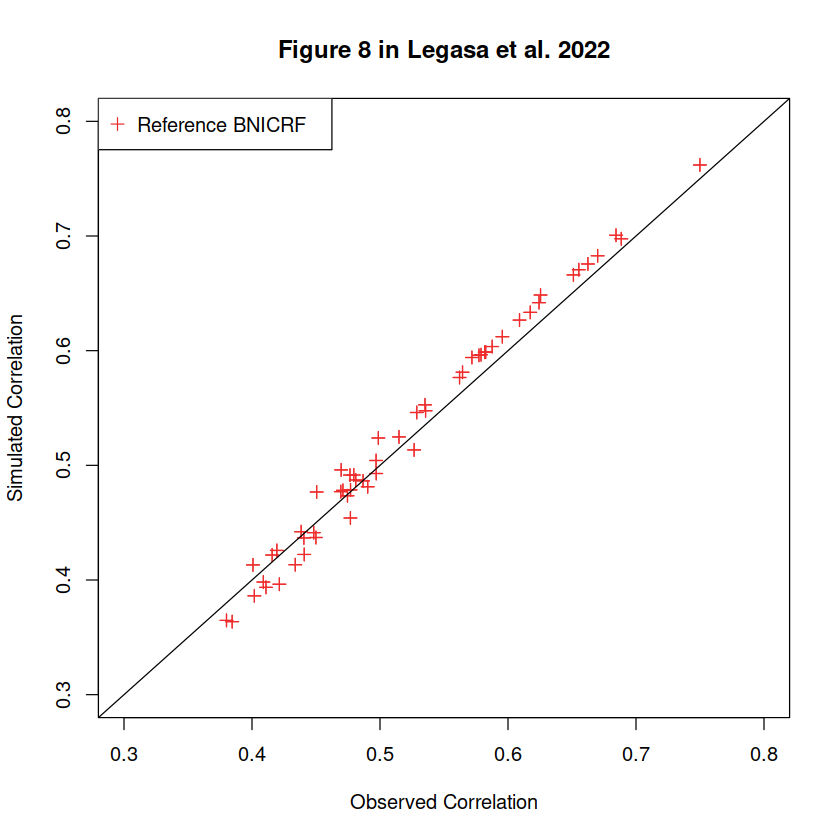

In [10]:
cor.bnicrf <- lapply(simulations, FUN = function(sim) cor(sim))

col.bnicrf <- "firebrick2"

plot(cor(test.Y$Data), apply(simplify2array(cor.bnicrf), MARGIN = c(1,2), FUN = mean), 
     xlim = c(0.3, 0.8),  ylim = c(0.3, 0.8), col = col.bnicrf, pch = 3,
     xlab = "Observed Correlation", ylab = "Simulated Correlation",
     main = "Figure 8 in Legasa et al. 2022")
lines(seq(0,1), seq(0,1))
legend("topleft",
       legend = c("Reference BNICRF"),
       pch = 3, 
       col = col.bnicrf)

Finally, we compute the validation measures and reproduce Figure 9. Note that the AUC and Brier Score require the probability values. We can obtain the exact values by multiplying the probabilities produced by the BNICRF (as output by `predictBNICRF()`) using the chain rule for probability. Nevertheless, here we compute them by averaging the $250$ series stored in `simulations`:

In [11]:
marginals <- apply(simplify2array(simulations), MARGIN = c(1,2), FUN = mean) # We average all simulations

BrierScore <-
  sapply(1:ncol(marginals), function(icol){
    mean((marginals[,icol] - test.Y$Data[, icol])^2)
  })

# Requires ROCR package:
AUC <-
  sapply(1:ncol(marginals), function(icol){
    auc <- sapply(ROCR::performance(
      ROCR::prediction(marginals[, icol], test.Y$Data[, icol])
      ,"auc")@y.values, function(x) x)
    auc
  })


R01  <- rowMeans(sapply(simulations, FUN = colMeans))/colMeans(test.Y$Data)


idxs <- getConsecutiveDatesIndex(test.Y$Dates$start) # previously checked consistency


bnicrf.AutoCor <-
  rowMeans(  
    do.call(cbind,
            lapply(simulations, function(sim){
              apply(sim, MARGIN = 2, FUN = function(simst){
                cor(simst[idxs$id_T], simst[idxs[, "id_T-1"]])
              })
            })
    )
  )


obs.AutoCor <-
  apply(test.Y$Data,  MARGIN = 2, function(obs){
    cor(obs[idxs$id_T], obs[idxs[, "id_T-1"]])
  })

AutoCor <- bnicrf.AutoCor/obs.AutoCor

SPCor <- apply(simplify2array(cor.bnicrf), MARGIN = c(1,2), FUN = mean)/cor(test.Y$Data)
SPCor <- unique(c(SPCor))[ -which(unique(c(SPCor)) == 1) ]


### THE SPELLS:
obs.spells <- getSpells(test.Y$Data, dates = test.Y$Dates$start)
bnicrf.spellS <- lapply(simulations, FUN = getSpells, dates = test.Y$Dates$start)


bnicrf.spellMeasures <- 
  apply(
    simplify2array(
      lapply(bnicrf.spellS, function(sim){
        do.call(rbind,
                mapply(obs.spells, sim,
                       FUN = function(obss, sims){
                         drysp <- obss[which(obss[ , "Occurrence"] == 0), ]
                         DrySpellMeanObs <- mean(drysp[which(drysp[, "Days"] > 1), "Days"])
                         
                         dryspsim <- sims[which(sims[ , "Occurrence"] == 0), ]
                         sims.DrySpellMean <- mean(dryspsim[which(dryspsim[, "Days"] > 1), "Days"])/DrySpellMeanObs
                         
                         wetsp <- obss[which(obss[ , "Occurrence"] == 1), ]
                         WetSpellMeanObs <- mean(wetsp[which(wetsp[, "Days"] > 1), "Days"])
                         
                         wetspsims <- sims[which(sims[ , "Occurrence"] == 1), ]
                         sims.WetSpellMean <- mean(wetspsims[which(wetspsims[, "Days"] > 1), "Days"])/WetSpellMeanObs
                         
                         
                         sims.DryLongestAnnualMean <-
                           mean(
                             sapply( unique(obss[, "Year"]), function(year){
                               years <- sims[which(sims[, "Year"] == year),]
                               drysp <- years[which(years[ , "Occurrence"] == 0), ]
                               max(drysp[, "Days"])
                             })
                           )/mean(
                             sapply( unique(obss[, "Year"]), function(year){
                               years <- obss[which(obss[, "Year"] == year),]
                               drysp <- years[which(years[ , "Occurrence"] == 0), ]
                               max(drysp[, "Days"])
                             })
                           )
                         
                         sims.WetLongestAnnualMean <-
                           mean(
                             sapply( unique(obss[, "Year"]), function(year){
                               years <- sims[which(sims[, "Year"] == year),]
                               drysp <- years[which(years[ , "Occurrence"] == 1), ]
                               max(drysp[, "Days"])
                             })
                           )/mean(
                             sapply( unique(obss[, "Year"]), function(year){
                               years <- obss[which(obss[, "Year"] == year),]
                               drysp <- years[which(years[ , "Occurrence"] == 1), ]
                               max(drysp[, "Days"])
                             })
                           )
                         
                         return(c(WetSpellMean = sims.WetSpellMean,
                                  DrySpellMean = sims.DrySpellMean,
                                  WetLongestMean = sims.WetLongestAnnualMean,
                                  DryLongestMean = sims.DryLongestAnnualMean
                         ))
                         
                         
                       }, SIMPLIFY = F)
        )
      })
    ), 
    MARGIN = c(1,2), 
    FUN = mean
  )



aux <- matrix(c(AUC, R01, BrierScore, AutoCor), ncol = 4)
colnames(aux) <- c("AUC", "R01", "Brier", "AutoCor")

validation <- cbind(aux, bnicrf.spellMeasures)

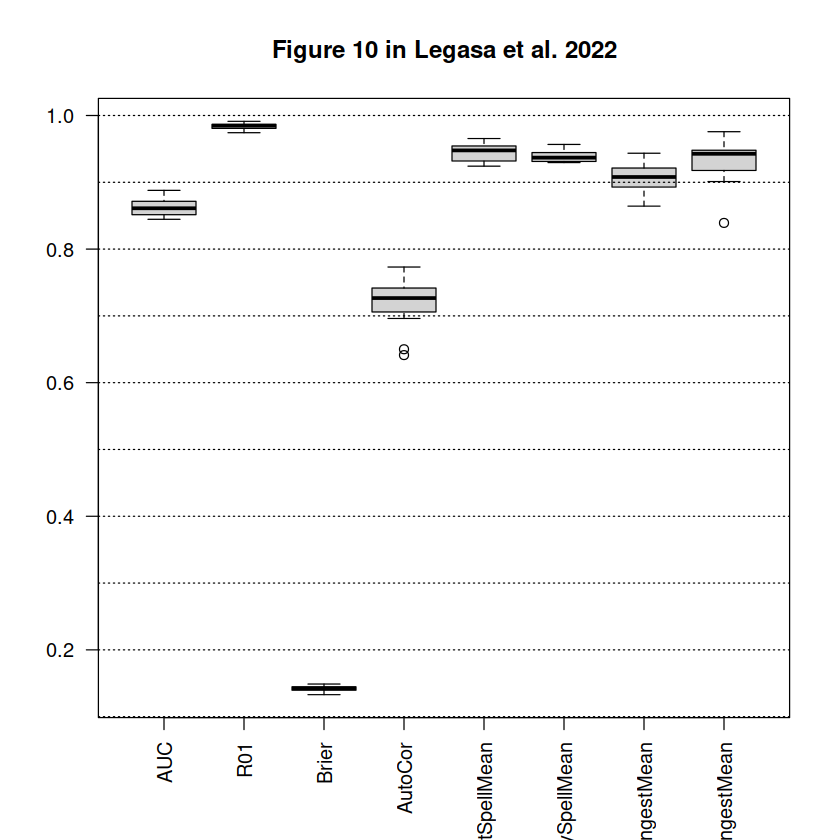

In [12]:
boxplot(validation, las = 2, main = "Figure 8 in Legasa et al. 2022")
null <- sapply(seq(from = 0.1, to = 1, by = 0.1), FUN = function(hl) abline(h = hl, lty = 3))